In [1]:
import os
import torch
import pandas as pd
from PIL import Image
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as f
from tqdm import tqdm

from networks.overfit_network import OverfitNN
from torch.optim import SGD
from torch.optim import Adam
from torch.nn import MSELoss
from torch.nn import L1Loss

from data.memory_dataset import MemoryData
from data.ssd_dataset import SSDData
from data.random_position_selector import RandomPartSelector
import torchvision.transforms.v2 as transforms

Image.MAX_IMAGE_PIXELS = None

%load_ext autoreload
%autoreload 2

In [2]:
transform = transforms.Compose(
    [RandomPartSelector(minimum_size=1024, output_size=1024),]
)

val_set = SSDData("data/perspective", transform, start=330, size=27)
train_set = SSDData("data/perspective", transform, 0, 330)



device = "cuda"

357
357


In [3]:
hp={
    "n1" : 32,
    "n2" : 64,
    "n3" : 128,
    "n4" : 256,
    "u3" : 256,
    "u2" : 256,
    "u1" : 256,
    "interface" : 256,
    "nupscaler" : 256
}

model = OverfitNN(hp=hp)

model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)


train_losses = []
val_losses = []

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters = count_parameters(model)

batch_size = 1
train_loader = DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size, drop_last=True)

print("Model has {} parameters".format(num_parameters))

Model has 2845987 parameters


In [4]:
loss_func = MSELoss()
#loss_func = L1Loss()

In [5]:
epochs = 1
import gc

#optimizer.lr=1e-3
for epoch in range(epochs):
    bar = tqdm(zip(range(len(train_set)), train_loader), total=int((len(train_set) - 1)/batch_size), desc="train {:0>5}".format(epoch), ncols=100)
    train_loss_sum = 0
    val_loss_sum = 0
    for i, batch in bar:
        gpu_batch = batch.to(device)
        
        down_image = f.interpolate(gpu_batch, scale_factor=(.5, .5), mode="bilinear", antialias=True)
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            model.train()
            model.zero_grad()
            prediction = model.forward(down_image)
        

            target = (gpu_batch - f.interpolate(down_image, scale_factor=(2,2), mode="bilinear"))*10
            del down_image
            del gpu_batch
            loss = loss_func(prediction, target)

            del target
            del prediction
            loss.backward()
            train_loss_sum += loss.item()
        
            optimizer.step()
        bar.set_postfix(loss = "{:.8f}".format(train_loss_sum / (i + 1)))

        

        
    train_losses.append(train_loss_sum / int((len(train_set) - 1)/batch_size))
    gc.collect()
    torch.cuda.empty_cache()
    model.eval()
    bar = tqdm(zip(range(len(val_set)), val_loader), total=int((len(val_set) - 1)/batch_size), desc="val {:0>5}".format(epoch), ncols=100)
    for i, batch in bar:
        gpu_batch = batch.to(device)
        down_image = f.interpolate(gpu_batch, scale_factor=(.5, .5), mode="bilinear", antialias=True)
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):

            prediction = model.forward(down_image)
        
            target = (gpu_batch - f.interpolate(down_image, scale_factor=(2,2), mode="bilinear"))*10
            del down_image
            loss = loss_func(prediction, target)
            val_loss_sum += loss.item()
        
            bar.set_postfix(loss = "{:.8f}".format(val_loss_sum / (i+ 1)))
        
        
            del gpu_batch
            del target
            del prediction
    val_losses.append(val_loss_sum /int((len(val_set) - 1)/batch_size))
    
    #model.eval()
    #prediction = model.forward(val_down_image)
    #loss = loss_func(prediction, val_target)
    #val_losses.append(loss.item())
    


train 00000: 330it [02:02,  2.69it/s, loss=0.14621162]                                              
val 00000: 27it [00:13,  1.93it/s, loss=0.17923138]                                                 


In [22]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1770 MiB |   3522 MiB |  30935 GiB |  30933 GiB |
|       from large pool |   1746 MiB |   3487 MiB |  30710 GiB |  30708 GiB |
|       from small pool |     24 MiB |     34 MiB |    225 GiB |    225 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1770 MiB |   3522 MiB |  30935 GiB |  30933 GiB |
|       from large pool |   1746 MiB |   3487 MiB |  30710 GiB |

In [24]:
gc.collect()
torch.cuda.empty_cache()

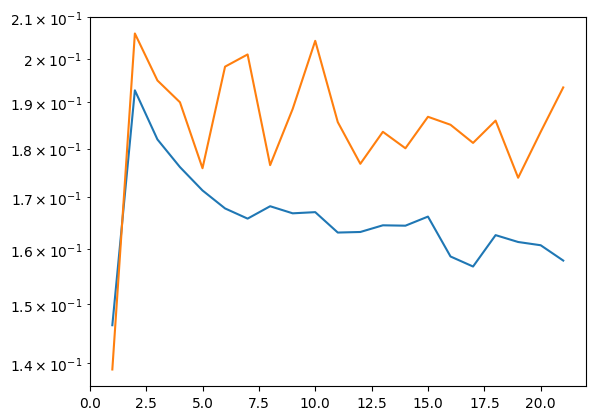

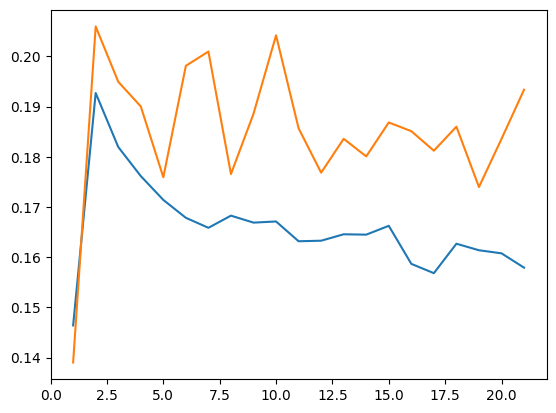

In [25]:
#black_loss = loss_func(torch.zeros(target.shape).to(device), target)
#black_loss_value = black_loss.item()
plt.plot(np.linspace(1, len(train_losses), len(train_losses)), train_losses)
plt.plot(np.linspace(1, len(val_losses), len(val_losses)), val_losses)
#plt.plot((0, len(losses)), (black_loss_value, black_loss_value))
#plt.plot(np.linspace(1, len(val_losses), len(val_losses)), val_losses)
plt.yscale("log")
plt.show()

plt.plot(np.linspace(1, len(train_losses), len(train_losses)), train_losses)
plt.plot(np.linspace(1, len(val_losses), len(val_losses)), val_losses)
plt.show()

RuntimeError: Input type (torch.cuda.HalfTensor) and weight type (torch.cuda.FloatTensor) should be the same

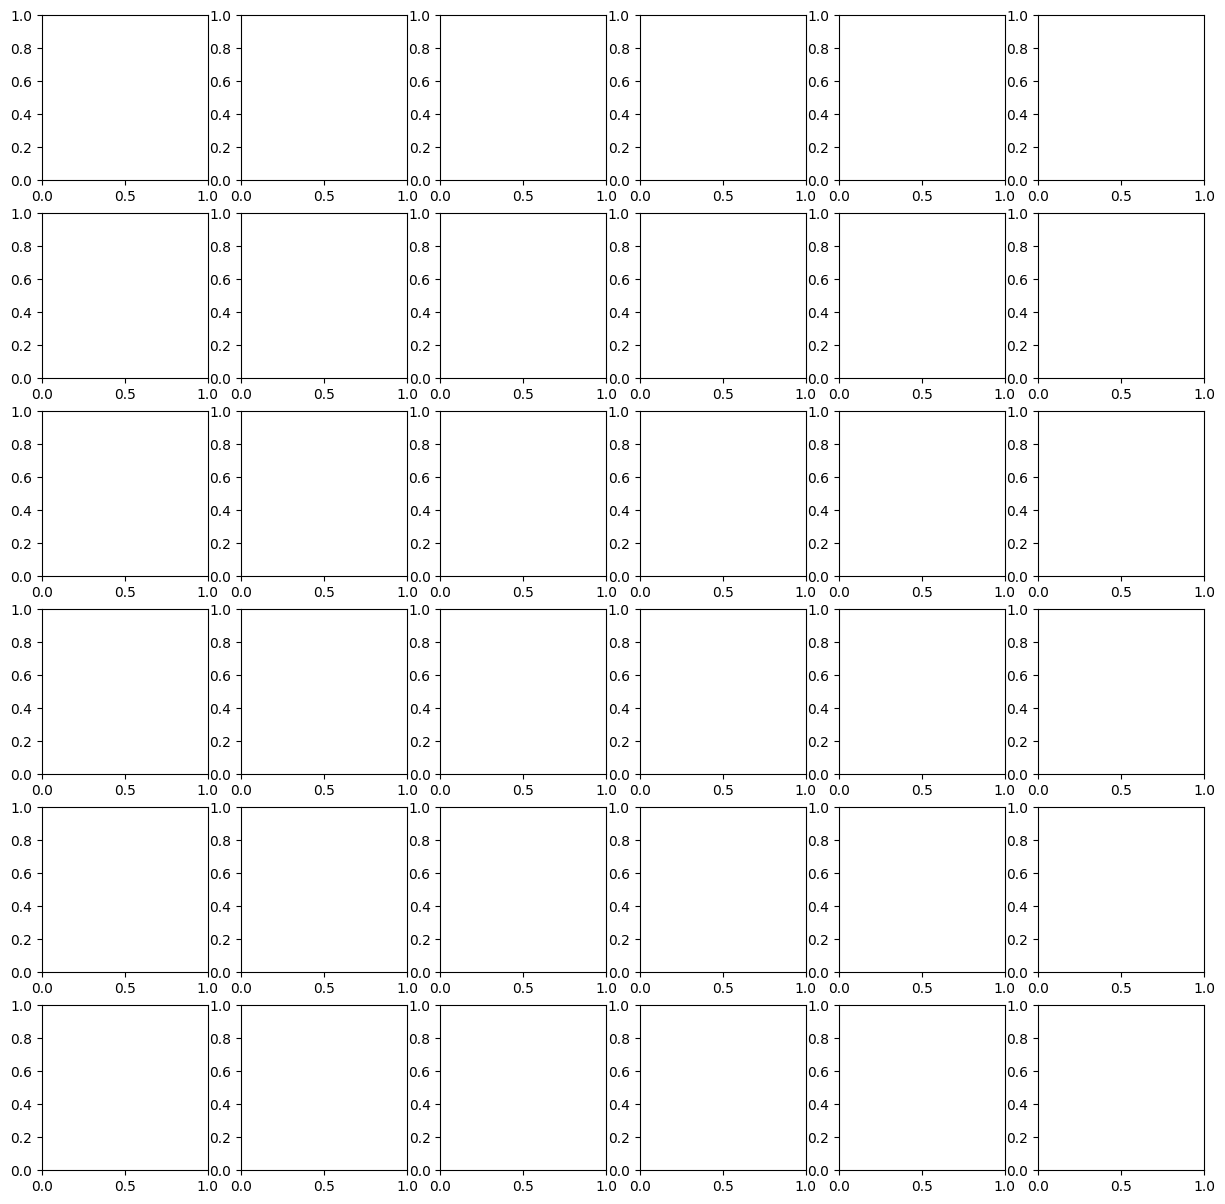

In [26]:
from visualization_tools import plot_upscaling
import random
import torchvision.transforms.v2 as transforms

train_image = train_set[random.randint(0, len(train_set) - 1)].unsqueeze(0)

val_image = val_set[random.randint(0, len(val_set) - 1)].unsqueeze(0)

plot_upscaling(val_image, model)

del val_image
del train_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.7085, device='cuda:0')


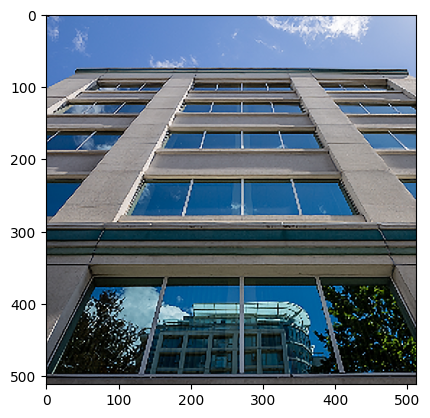

In [36]:
image = val_set[random.randint(0, len(val_set) - 1)].unsqueeze(0)

very_down_image = f.interpolate(image, scale_factor=(.25, .25))
model.eval()
upscaled_image = f.interpolate(very_down_image, scale_factor=(2,2)) + model.forward(very_down_image).detach() / 10
twice_upscaled_image = f.interpolate(upscaled_image, scale_factor=(2,2)) + model.forward(upscaled_image).detach() / 10

print(torch.max(upscaled_image))

plt.imshow(upscaled_image.cpu().squeeze(0).permute(1,2,0))

In [37]:
to_pil_image = transforms.ToPILImage()

pil_image = to_pil_image(upscaled_image.clamp(0, 1).cpu().squeeze(0))
pil_image.save("output.png")

In [25]:
del image
del val_image
del train_image
del very_down_image
del upscaled_image
del twice_upscaled_image

NameError: name 'val_image' is not defined

In [28]:
torch.save(model.state_dict(), "PerspectiveNetV2.pt")